In [1]:
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = COLORS.keys()

############ Load linear regression data #############
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "strreg", "%s_strreg.tab"%t), sep="\t", usecols=["gene","str.start","p.wald"])
    data[t]["str.start"] = (data[t]["str.start"]).apply(int)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def ExtractData(gene, chrom, start, tissue, newdata=True):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    if newdata:
        expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Review_Rerun/%s/Corr_Expr.csv"%tissue
    else: expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=None, newdata=True, period=None):
    ExtractData(gene, chrom, start, tissue, newdata=newdata)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
    fig = plt.figure()
    fig.set_size_inches((8,5))
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
        
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]
    print(set(data["str"]))
    boxcol = "gray"
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="black", zorder=0)
    sns.boxplot(x="str", y="expr", ax=ax, data=data, color="white", linewidth=0.5, 
                boxprops={'facecolor':'None', 'edgecolor': boxcol}, showfliers=False)
    # Set box properties
    for i,artist in enumerate(ax.artists):
        artist.set_edgecolor(boxcol)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        x = 5
        for j in range(i*x,i*x+x):
            line = ax.lines[j]
            line.set_color(boxcol)
            line.set_mfc(boxcol)
            line.set_mec(boxcol)
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="red", marker="o", linewidth=2)
    ax.set_xlabel("Mean num. rpts.", size=15)
    ax.set_ylabel("Normalized Expression - %s"%tissue, size=15)
    ax.set_xticklabels(["%.1f"%((item*0.5+reflen)/period) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.1f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("%s %s %s"%(chrom, start,gene))
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)

{0, -24, -12}


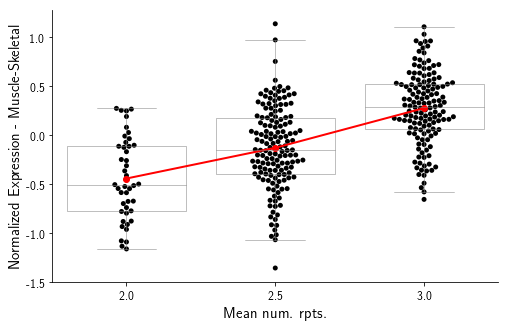

In [12]:
# CSTB
chrom = "chr21"
start = 45196326
end = 45196360
gene = "ENSG00000160213.5"
tissue = "Muscle-Skeletal"
period = 12
offset = 1
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "Figure1_Example_CSTB.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 36, 6, 42, 12, 48, 18, -12, 24, -6, 30}


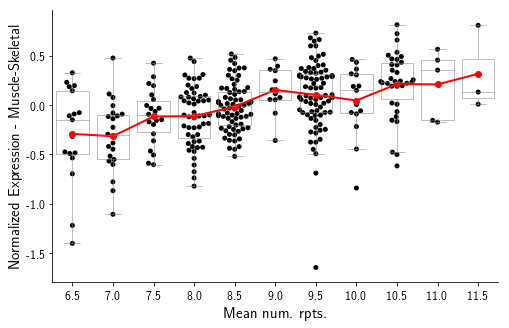

In [13]:
# NOP56
chrom="chr20"
start=2633379
end = 2633421
gene = "ENSG00000101361.10"
tissue = "Muscle-Skeletal"
period = 6
offset = 2
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "Figure1_Example_NOP56.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 6, -24, -18, -12, -6}


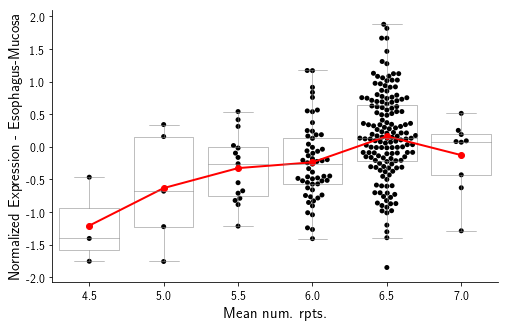

In [14]:
# ALOX5
gene = "ENSG00000012779.6"
chrom = "chr10"
start = 45869548
end = 45869585
tissue = "Esophagus-Mucosa"
period = 6
offset = 1
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "Figure1_Example_ALOX5.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{-8, 0, -16, -12, -4}


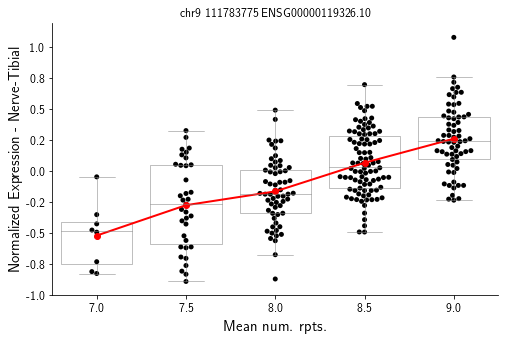

In [53]:
# CTNNAL1 - score 0.65
chrom = "chr9"
start = 111783775
end = 111783810
gene = "ENSG00000119326.10"
period=4
offset=0
reflen = (end+1+offset-start)
tissue="Nerve-Tibial"
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_CTNNAL1.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24}


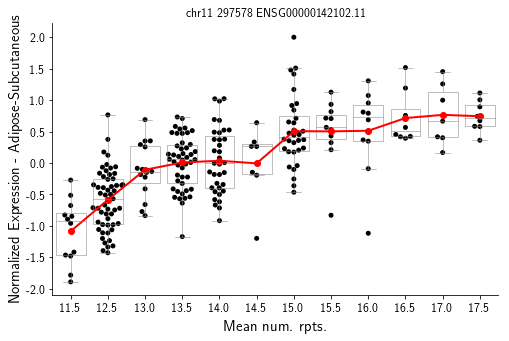

In [54]:
# ATHL1 - score 0.98
chrom = "chr11"
start = 297578
end = 297600
gene = "ENSG00000142102.11"
tissue="Adipose-Subcutaneous"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_ATHL1.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 2, -4, -2}


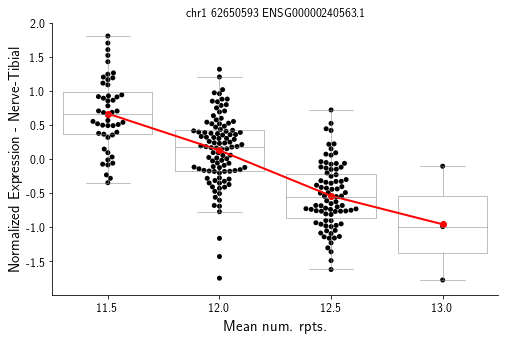

In [55]:
# L1TD1 
chrom = "chr1"
start = 62650593
end = 62650617
gene = "ENSG00000240563.1"
tissue="Nerve-Tibial"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_L1TD1.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{-8, 0, -16, -4, -12}


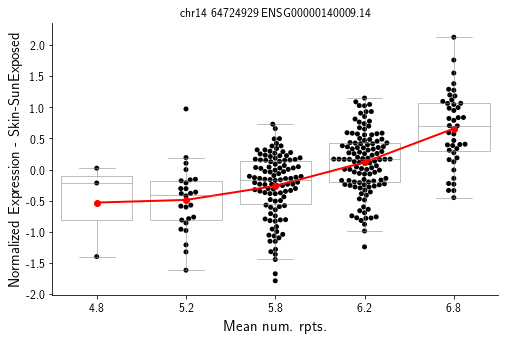

In [56]:
# ESR2
chrom = "chr14"
start = 64724929
end = 64724955
gene = "ENSG00000140009.14"
tissue="Skin-SunExposed"
period=4
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_ESR2.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{-20, -18, -16, -14, -12, -10, -8, -6}


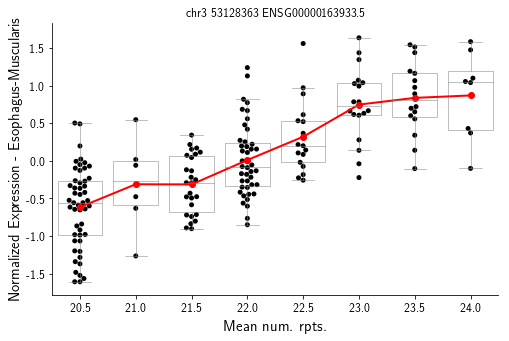

In [36]:
# RFT1 - 
chrom = "chr3"
start = 53128363
end = 53128413
gene = "ENSG00000163933.5"
tissue="Esophagus-Muscularis"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_RFT1.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 3, 6, 9, 12, 15}


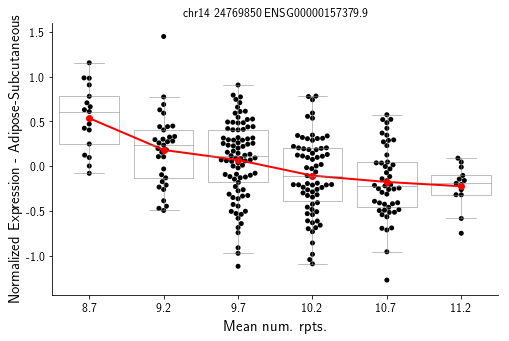

In [60]:
# DHRS1
chrom = "chr14"
start = 24769850
end = 24769875
gene = "ENSG00000157379.9"
tissue="Adipose-Subcutaneous"
period=3
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_DHRS1.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 8, 4, -4}


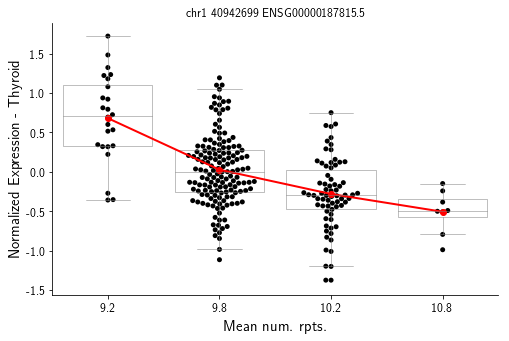

In [61]:
# ZFP69
chrom = "chr1"
start = 40942699
end = 40942737
gene = "ENSG00000187815.5"
tissue="Thyroid"
period=4
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_ZFP69.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, -30, -24, -18, -12, -6, -36}


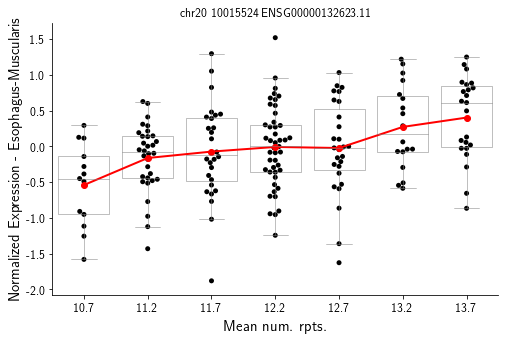

In [63]:
# ANKEF1
chrom = "chr20"
start = 10015524
end = 10015605
gene = "ENSG00000132623.11"
tissue="Esophagus-Muscularis"
period=6
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_ANKEF1.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 2, 4, 6, 8, 10}


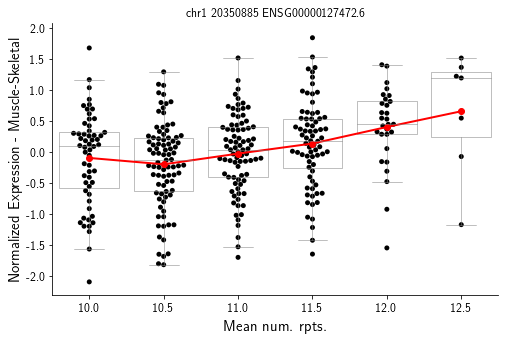

In [64]:
# PLA2G5
chrom = "chr1"
start = 20350885
end = 20350904
gene = "ENSG00000127472.6"
tissue="Muscle-Skeletal"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_PLA2G5.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 1, 2, -2, -1}


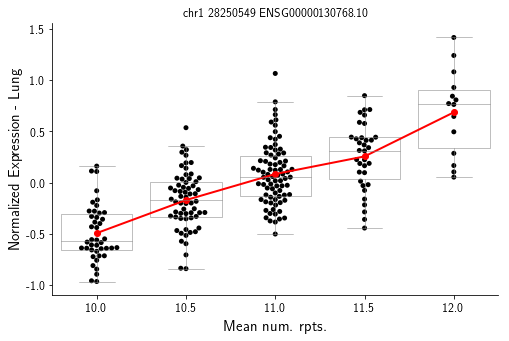

In [65]:
# SMPDL3B
chrom = "chr1"
start = 28250549
end = 28250559
gene = "ENSG00000130768.10"
tissue="Lung"
period=1
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_SMPDL3B.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 1, 2, 3, 4}


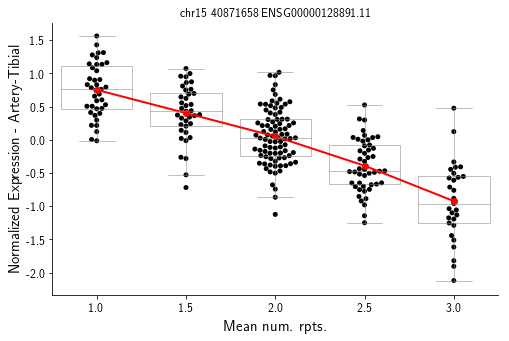

In [66]:
# C15orf57
chrom = "chr15"
start = 40871658
end = 40871658
gene = "ENSG00000128891.11"
tissue="Artery-Tibial"
period=1
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_MultiAllelc_C15orf57.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 10, 5}


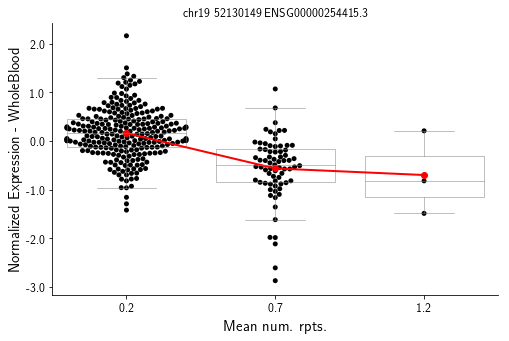

In [4]:
# SIGLEC14
chrom = "chr19"
start = 52130149
end = 52130149
gene = "ENSG00000254415.3"
tissue="WholeBlood"
period=5
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_SIGLEC14.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 8, 2, 12, 6}


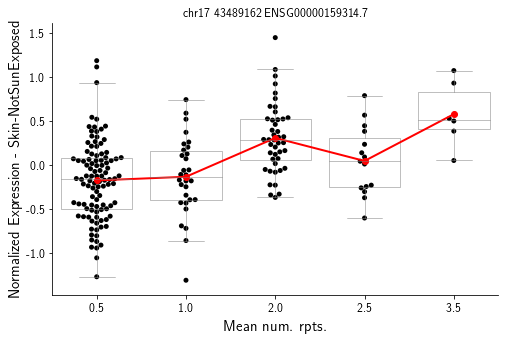

In [6]:
# ARHGAP27
chrom = "chr17"
start = 43489162
end = 43489162
gene = "ENSG00000159314.7"
tissue="Skin-NotSunExposed"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_ARHGAP27.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 1, -1, -2}


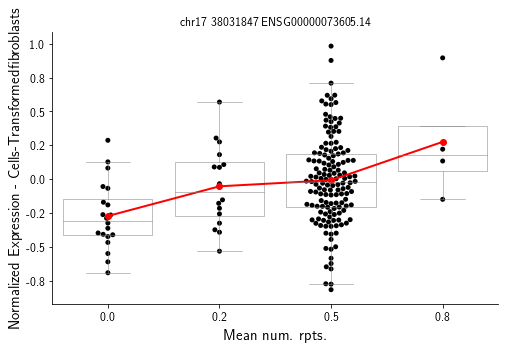

In [9]:
# GSDMB
chrom = "chr17"
start = 38031847
end = 38031847
gene = "ENSG00000073605.14"
tissue="Cells-Transformedfibroblasts"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_GSDMB.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 6, 12, 18, -12, 24, -6}


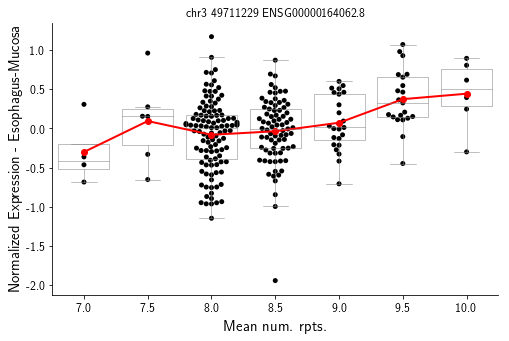

In [7]:
# APEH
chrom = "chr3"
start = 49711229
end = 49711275
gene = "ENSG00000164062.8"
tissue="Esophagus-Mucosa"
period=6
offset=1
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_APEH.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 8, 2, 12, 6}


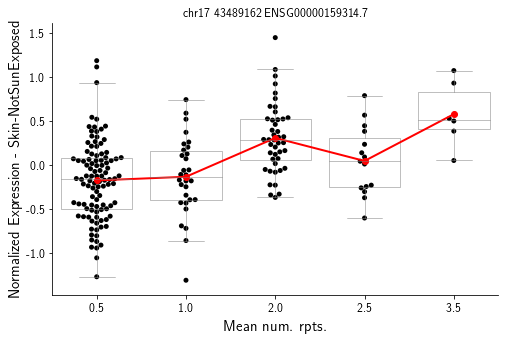

In [14]:
# ARHGAP27
chrom = "chr17"
start = 43489162
end = 43489162
gene = "ENSG00000159314.7"
tissue="Skin-NotSunExposed"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_ARHGAP27.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 2, 4, -12, -10, -8, -6, -4, -2}


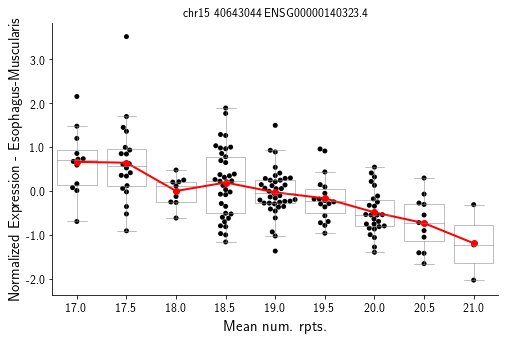

In [5]:
# DISP2
chrom = "chr15"
start = 40643044
end = 40643083
gene = "ENSG00000140323.4"
tissue="Esophagus-Muscularis"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_DISP2.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 1, 2, 3}


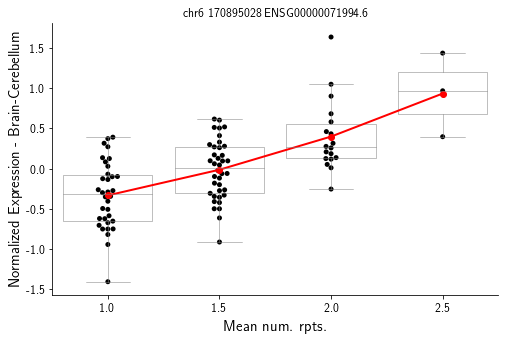

In [19]:
# PDCD2
chrom = "chr6"
start = 170895028
end = 170895028
gene = "ENSG00000071994.6"
tissue="Brain-Cerebellum"
period=1
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_PDCD2.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 2, -12, -10, -8, -6, -4, -2}


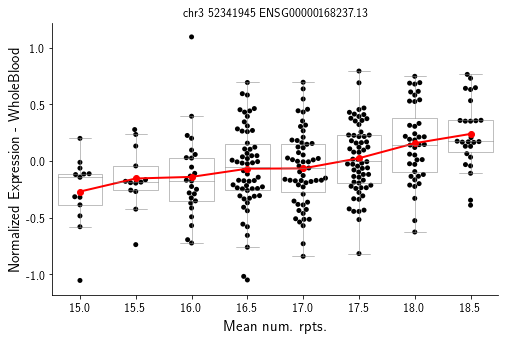

In [4]:
# GLYCTK
chrom = "chr3"
start = 52341945
end = 52341980
gene = "ENSG00000168237.13"
tissue="WholeBlood"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_GLYCTK.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 2, 4, 6, 8, 10, 12, -4, -2}


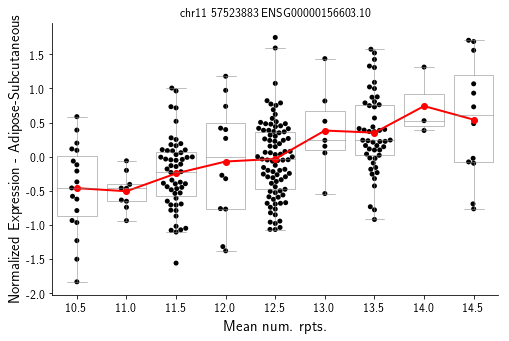

In [8]:
# MED19
chrom = "chr11"
start = 57523883
end = 57523905
gene = "ENSG00000156603.10"
tissue="Adipose-Subcutaneous"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_MED19.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 2, 4, 6, 8, 10, 12, 14, 16, -16, -14, 18, -8, -6, -4, -2}


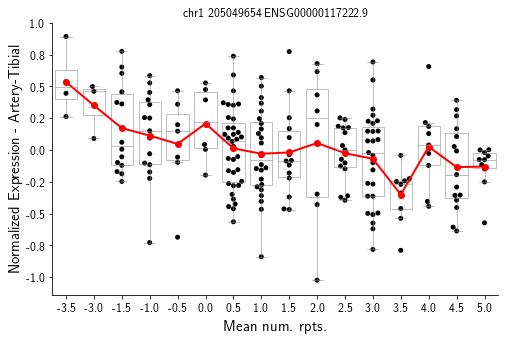

In [23]:
# RBBP5
chrom = "chr1"
start = 205049654
end = 205049654
gene = "ENSG00000117222.9"
tissue="Artery-Tibial"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_RBBP5.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, -30, 3, -27, 6, -24, 9, -21, 12, -18, 15, -48, -15, -12, -42, -9, 24, -39, -6, -3}


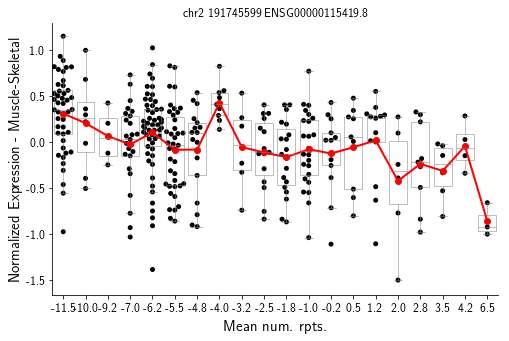

In [24]:
# GLS
chrom = "chr2"
start = 191745599
end = 191745599
gene = "ENSG00000115419.8"
tissue="Muscle-Skeletal"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_GLS.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 3, 6, 9, 12, -6, -3}


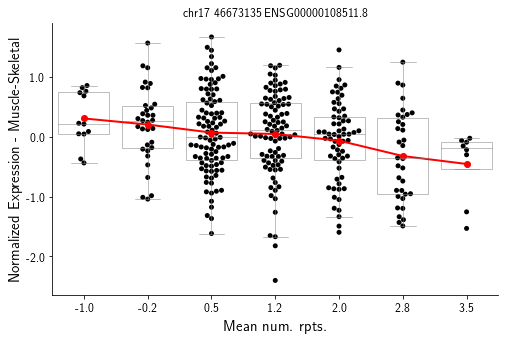

In [34]:
# HOXB6
chrom = "chr17"
start = 46673135
end = 46673135
gene = "ENSG00000108511.8"
tissue="Muscle-Skeletal"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_HOXB6.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 1, 2}


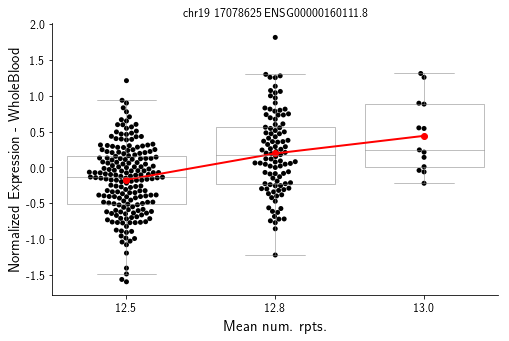

In [10]:
# CPAMD8
chrom = "chr19"
start = 17078625
end = 17078649
gene = "ENSG00000160111.8"
tissue="WholeBlood"
period=2
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_CPAMD8.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, -30, 5, -25, 10, -20, 15, -15, -10, -40, -5}


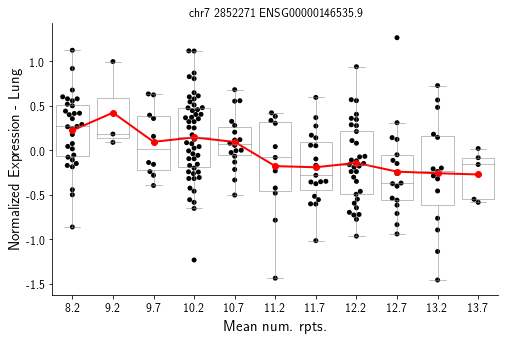

In [11]:
# GNA12
chrom = "chr7"
start = 2852271
end = 2852331
gene = "ENSG00000146535.9"
tissue="Lung"
period=5
offset=0
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_GNA12.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)

{0, 8, 4}


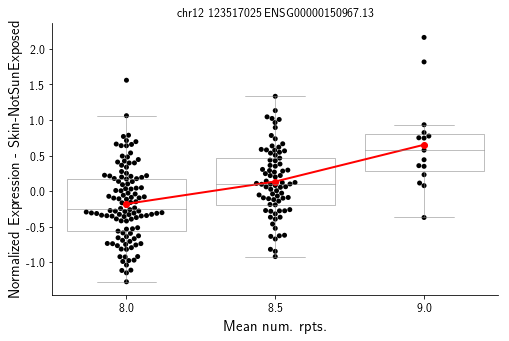

In [13]:
# ABCB9
chrom = "chr12"
start = 123517025
end = 123517055
gene = "ENSG00000150967.13"
tissue="Skin-NotSunExposed"
period=4
offset=1
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "SuppFig_GWAS_ABCB9.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname, period=period)